In [1]:
!pip install datasets transformers rouge_score nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 95.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.6 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=b05539a83aa0cc3c585d0fd0c40f6ad345038d300e9f8e637a33c93ae2f02c4e
  Stored in directory: /root/.cache/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import transformers
from datasets import load_dataset, load_metric
import pandas as pd
import numpy as np

In [9]:
base_dataset = load_dataset("json", data_files="drive/MyDrive/data2050/data/large_set.json")
dataset = base_dataset.shuffle(seed=2394578)


dataset = dataset.filter(lambda example: example["label"] is not None)
dataset = dataset.rename_column("label", "title")
datasets_train_test = dataset["train"].train_test_split(test_size=30)
datasets_train_validation = datasets_train_test["train"].train_test_split(test_size=30)

dataset["train"] = datasets_train_validation["train"]
dataset["validation"] = datasets_train_validation["test"]
dataset["test"] = datasets_train_test["test"]

dataset = dataset.remove_columns("__index_level_0__")

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'title'],
        num_rows: 926
    })
    validation: Dataset({
        features: ['text', 'title'],
        num_rows: 30
    })
    test: Dataset({
        features: ['text', 'title'],
        num_rows: 30
    })
})

In [11]:
import nltk
nltk.download('punkt')
import string
from transformers import AutoTokenizer

model_checkpoint = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,model_max_length = 512, truncation = True)
tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


PreTrainedTokenizerFast(name_or_path='t5-base', vocab_size=32100, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<ext

In [12]:
clean_dataset = dataset.filter(
    lambda example: (len(example['text']) >= 30) and
    (len(example['title']) >= 10)
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [13]:
clean_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'title'],
        num_rows: 905
    })
    validation: Dataset({
        features: ['text', 'title'],
        num_rows: 30
    })
    test: Dataset({
        features: ['text', 'title'],
        num_rows: 30
    })
})

In [14]:
prefix = "summarize: "
prefix = ""
max_input_length = 512
max_target_length = 50



def clean_text(text):
    sentences = nltk.sent_tokenize(text.strip())
    sentences_cleaned = [s for sent in sentences for s in sent.split("\n")]
    sentences_cleaned_no_titles = [sent for sent in sentences_cleaned
                                 if len(sent) > 0 and
                                 sent[-1] in string.punctuation]
    text_cleaned = "\n".join(sentences_cleaned_no_titles)
    return text_cleaned

def preprocess_data(examples):
    texts_cleaned = [clean_text(text) for text in examples["text"]]
    inputs = [prefix + text for text in texts_cleaned]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    print("past tokenizer")
      # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["title"], max_length=max_target_length, 
                           truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [15]:
tokenized_dataset = clean_dataset.map(preprocess_data,batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

past tokenizer


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

past tokenizer


  0%|          | 0/1 [00:00<?, ?ba/s]

past tokenizer


In [16]:

tokenized_dataset["train"]

Dataset({
    features: ['text', 'title', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 905
})

In [17]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq,Seq2SeqTrainingArguments, Seq2SeqTrainer

In [18]:
batch_size = 1
model_name = "t5-base-text_description-generation-beta"
model_dir = f"drive/MyDrive/data2050/Models/{model_name}"

args = Seq2SeqTrainingArguments(
    model_dir,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=200,
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    report_to="tensorboard"
)

In [19]:
data_collator = DataCollatorForSeq2Seq(tokenizer)

In [20]:
metric = load_metric("rouge")

<ipython-input-20-7154407f1f07>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


In [21]:
def compute_metrics(eval_pred):
    print("in compute metrics")
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                      for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
                      for label in decoded_labels]
    
    # Compute ROUGE scores
    result = metric.compute(predictions=decoded_preds, references=decoded_labels,
                            use_stemmer=True)

    # Extract ROUGE f1 scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length to metrics
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                      for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    print("out of compute metrics")
    return {k: round(v, 4) for k, v in result.items()}

In [22]:
def model_init():
    return AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

trainer = Seq2SeqTrainer(
    model_init=model_init,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
  

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/pytorch_model.bin
All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.
Using cuda_amp half precision backend


In [23]:
#%load_ext tensorboard
#%tensorboard --logdir '{model_dir}'/runs

In [24]:
trainer.train()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
  

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
100,4.899300,3.340114,11.876500,7.138600,11.234800,11.543300,10.766700
200,3.221900,2.932724,15.671700,7.429200,14.194100,14.473200,9.333300
300,2.651100,2.605367,55.728300,39.994500,54.804900,54.816900,8.966700
400,2.654600,2.491832,58.167800,42.131000,56.883800,57.099000,7.166700
500,2.482400,2.468249,59.983600,43.063500,58.583900,58.768900,7.000000
600,2.133600,2.427650,58.214600,42.960300,57.501800,57.626600,7.033300
700,2.234100,2.402979,60.320100,45.689900,59.069400,59.223200,7.166700
800,2.301500,2.387155,58.021000,42.493400,57.198800,57.408200,7.066700
900,2.277700,2.380825,58.021000,42.493400,57.198800,57.408200,7.066700


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-200
Configuration saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-200/config.json
Model weights saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-200/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-200/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-200/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-400
Configuration saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-400/config.json
Model weights saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-400/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-400/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-400/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-600
Configuration saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-600/config.json
Model weights saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-600/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-600/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-600/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-800
Configuration saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-800/config.json
Model weights saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-800/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-800/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-800/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-200] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration

in compute metrics
out of compute metrics




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from drive/MyDrive/data2050/Models/t5-base-text_description-generation-beta/checkpoint-600 (score: 58.2146).


TrainOutput(global_step=905, training_loss=2.757334514217482, metrics={'train_runtime': 356.8257, 'train_samples_per_second': 2.536, 'train_steps_per_second': 2.536, 'total_flos': 81460011571200.0, 'train_loss': 2.757334514217482, 'epoch': 1.0})

In [ ]:
trainer.state.log_history

[{'loss': 3.8505,
  'learning_rate': 2.794871794871795e-05,
  'epoch': 0.32,
  'step': 100},
 {'eval_loss': 2.8744394779205322,
  'eval_rouge1': 13.4307,
  'eval_rouge2': 3.2334,
  'eval_rougeL': 11.729,
  'eval_rougeLsum': 11.5669,
  'eval_gen_len': 13.1667,
  'eval_runtime': 7.9125,
  'eval_samples_per_second': 3.791,
  'eval_steps_per_second': 3.791,
  'epoch': 0.32,
  'step': 100},
 {'loss': 2.7238,
  'learning_rate': 1.5128205128205129e-05,
  'epoch': 0.64,
  'step': 200},
 {'eval_loss': 2.633535623550415,
  'eval_rouge1': 19.9757,
  'eval_rouge2': 6.7104,
  'eval_rougeL': 17.1237,
  'eval_rougeLsum': 17.265,
  'eval_gen_len': 13.9667,
  'eval_runtime': 8.1698,
  'eval_samples_per_second': 3.672,
  'eval_steps_per_second': 3.672,
  'epoch': 0.64,
  'step': 200},
 {'loss': 2.6129,
  'learning_rate': 2.307692307692308e-06,
  'epoch': 0.96,
  'step': 300},
 {'eval_loss': 2.5792837142944336,
  'eval_rouge1': 21.1326,
  'eval_rouge2': 7.9874,
  'eval_rougeL': 18.677,
  'eval_rougeLsum'

In [26]:
import json

In [27]:
metrics = trainer.state.log_history
json_object = json.dumps(metrics)
json_object
with open("sample.json", "w") as outfile:
    outfile.write(json_object)

In [28]:
predictions = trainer.predict(tokenized_dataset["test"])


The following columns in the test set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


In [29]:

decoded_output = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=False)
for input, output, ideal_output in zip(dataset["test"]["text"],decoded_output, dataset["test"]["title"]):
  print(f"input: {input}")
  print(f"output: {output}")
  print(f"real label: {ideal_output}")
  print()

input: You know the story of the ant and the grasshopper? The ant works hard, plans for the future, prepares and stores food for winter. Grasshopper fucks around all summer, procrastinates, does whatever he wants and when winter comes he's caught off guard and underprepared. 

Well, in the brain of an ADHD person, the ant is having a nap and the grasshopper is running the show. They have difficulty with executive function (future planning, seeing how decisions will impact them later, foreseeing consequences, benefits of delayed gratification and things of this nature.) Basically the part of the brain that tells you "that's a bad idea" or "you shouldn't do that" or "you should be doing..." is under active. This is why stimulants are used to treat ADHD.  They give the ant part of the brain a jolt and help him rein in the grasshopper.
output: <pad> the brain of an ADHD person</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
real label: effect of ADHD on the brain

input: If

In [ ]:

#lets run across a few random seeds:
RUN_BLOCKER.COMMENT_IF_YOU_WANT
base_dataset = load_dataset("json", data_files="drive/MyDrive/data2050/data/small_set.json")


metric = load_metric("rouge")
for random_seed in range(10,15):
    print(f"\n\n\n\n\n{random_seed}\n\n\n\n\n")
    dataset = base_dataset.shuffle(seed=random_seed)


    dataset = dataset.filter(lambda example: example["label"] is not None)
    dataset = dataset.rename_column("label", "title")
    datasets_train_test = dataset["train"].train_test_split(test_size=30,seed = random_seed)
    datasets_train_validation = datasets_train_test["train"].train_test_split(test_size=30,seed = random_seed)

    dataset["train"] = datasets_train_validation["train"]
    dataset["validation"] = datasets_train_validation["test"]
    dataset["test"] = datasets_train_test["test"]


    model_checkpoint = "t5-base"
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,model_max_length = 512, truncation = True)

    def compute_metrics(eval_pred):
        print("in compute metrics")
        predictions, labels = eval_pred
        decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        
        # Rouge expects a newline after each sentence
        decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                          for pred in decoded_preds]
        decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
                          for label in decoded_labels]
        
        # Compute ROUGE scores
        result = metric.compute(predictions=decoded_preds, references=decoded_labels,
                                use_stemmer=True)

        # Extract ROUGE f1 scores
        result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
        
        # Add mean generated length to metrics
        prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                          for pred in predictions]
        result["gen_len"] = np.mean(prediction_lens)
        print("out of compute metrics")
        return {k: round(v, 4) for k, v in result.items()}
    
    def clean_text(text):
        sentences = nltk.sent_tokenize(text.strip())
        sentences_cleaned = [s for sent in sentences for s in sent.split("\n")]
        sentences_cleaned_no_titles = [sent for sent in sentences_cleaned
                                    if len(sent) > 0 and
                                    sent[-1] in string.punctuation]
        text_cleaned = "\n".join(sentences_cleaned_no_titles)
        return text_cleaned

    def preprocess_data(examples):
        texts_cleaned = [clean_text(text) for text in examples["text"]]
        inputs = [prefix + text for text in texts_cleaned]
        model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
        print("past tokenizer")
          # Setup the tokenizer for targets
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(examples["title"], max_length=max_target_length, 
                              truncation=True)

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs
    
    
    clean_dataset = dataset.filter(lambda example: (len(example['text']) >= 30) and (len(example['title']) >= 10))

    tokenized_dataset = clean_dataset.map(preprocess_data,batched=True)


    batch_size = 1  
    model_name = f"t5-base-text_description_{random_seed}"
    model_dir = f"drive/MyDrive/data2050/Models/random_seeds/{model_name}"

    args = Seq2SeqTrainingArguments(
        model_dir,
        evaluation_strategy="steps",
        eval_steps=100,
        logging_strategy="steps",
        logging_steps=100,
        save_strategy="steps",
        save_steps=200,
        learning_rate=4e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        save_total_limit=3,
        num_train_epochs=5,
        predict_with_generate=True,
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="rouge1",
        report_to="tensorboard")
    data_collator = DataCollatorForSeq2Seq(tokenizer)

    def model_init():
        return AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

    trainer = Seq2SeqTrainer(
        model_init=model_init,
        args=args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics)


    trainer.train()

    metric_file = trainer.state.log_history
    json_object = json.dumps(metric_file)
    with open(f"drive/MyDrive/data2050/data/model_histories/{model_name}_history.json", "w") as outfile:
        outfile.write(json_object)
    
    predictions = trainer.predict(tokenized_dataset["test"])
    decoded_output = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=False)
    test_examples = []
    for input, output, ideal_output in zip(dataset["test"]["text"],decoded_output, dataset["test"]["title"]):
          test_examples.append("\n".join([f"input: {input}",f"output: {output}",f"real label: {ideal_output}"]))
    full_examples = "\n\n".join(test_examples)

    with open(f"drive/MyDrive/data2050/data/model_histories/{model_name}_examples.txt", "w") as f:
      f.write(full_examples)

  

    
    

  0%|          | 0/1 [00:00<?, ?it/s]






10







Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalt

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
100,3.692400,2.567756,17.212100,8.416700,16.626400,16.363000,15.133300
200,2.612400,2.188637,28.342800,13.421200,26.866000,26.982500,13.233300
300,2.472100,1.918588,34.639500,20.659800,33.672900,33.977600,9.200000
400,1.792500,1.780274,48.638800,30.899200,47.751400,48.232500,9.333300
500,1.671600,1.724222,53.368900,34.955800,50.892100,51.214400,8.800000
600,1.820500,1.693460,51.760200,34.521800,49.917700,50.280100,9.033300
700,1.424300,1.653469,52.564300,36.820500,50.778800,51.101600,9.866700
800,1.520700,1.621007,53.471600,37.148800,52.237700,52.398100,9.966700
900,1.243900,1.606274,51.303700,34.577500,49.525700,49.716000,9.233300
1000,1.481500,1.612691,51.132700,33.374000,49.687100,49.864100,9.100000


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-200
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-200/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-200/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-200/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-200/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-400
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-400/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-400/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-400/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-400/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-800] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-600
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-600/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-600/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-600/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-600/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1400] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneratio

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-800
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-800/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-800/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-800/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-800/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-200] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1000
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1000/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1000/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-400] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1200
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1200/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1200/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1200/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1200/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-600] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1400
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1400/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1400/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1400/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1400/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-1000] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGene

in compute metrics
out of compute metrics




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_10/checkpoint-800 (score: 53.4716).
The following columns in the test set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics





11







  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalt

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

past tokenizer


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

past tokenizer


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices


past tokenizer


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
  

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
100,3.749500,2.231647,17.623300,7.442900,16.858200,17.045700,13.633300
200,2.854300,1.869837,33.329000,14.457600,29.717200,30.352100,11.600000
300,2.439500,1.639965,31.961800,14.154700,28.748000,28.858100,11.133300
400,2.114400,1.495043,47.555000,27.791400,45.336200,45.275100,9.566700
500,1.770400,1.395053,60.910600,39.747000,58.545600,57.864100,9.466700
600,1.638400,1.365196,61.179700,40.762900,58.844300,58.724100,9.233300
700,1.680900,1.368652,63.215000,41.968300,61.801200,61.326700,9.533300
800,1.487500,1.354593,61.879600,42.790700,60.201900,60.202100,9.700000
900,1.335100,1.313375,63.108300,44.208900,60.695000,60.469700,9.600000
1000,1.222300,1.327331,63.371500,44.208900,61.165900,60.905400,9.633300


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-200
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-200/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-200/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-200/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-200/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-400
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-400/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-400/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-400/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-400/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-600
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-600/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-600/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-600/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-600/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-800
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-800/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-800/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-800/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-800/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-200] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1000
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1000/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1000/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-400] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1200
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1200/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1200/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1200/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1200/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-600] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1400
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1400/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1400/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1400/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1400/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-800] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_11/checkpoint-1400 (score: 64.9646).
The following columns in the test set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics





12







  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalt

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

past tokenizer


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

past tokenizer


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices


past tokenizer


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
  

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
100,4.067900,2.331788,26.145000,9.728200,22.721200,22.475200,13.266700
200,2.632600,2.021600,30.892400,10.230200,27.586200,27.374500,11.966700
300,2.313500,1.857370,29.931000,12.129000,28.337100,28.530100,10.033300
400,1.841000,1.748311,48.291600,30.177500,46.234500,46.120900,10.066700
500,1.809000,1.676894,54.829400,36.117400,52.606300,52.922000,9.466700
600,1.739400,1.649056,61.464300,40.931500,59.094700,59.273000,8.266700
700,1.304700,1.663531,61.741300,41.445900,59.453200,59.725700,9.033300
800,1.580000,1.683590,59.307600,36.838900,57.055400,57.313800,9.466700
900,1.334600,1.696047,59.117300,38.264200,57.049700,57.190200,9.133300
1000,1.157600,1.722757,59.852900,38.418600,57.793300,58.082800,9.366700


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-200
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-200/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-200/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-200/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-200/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-400
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-400/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-400/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-400/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-400/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-600
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-600/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-600/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-600/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-600/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-800
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-800/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-800/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-800/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-800/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-200] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1000
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1000/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1000/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-400] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1200
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1200/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1200/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1200/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1200/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-800] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1400
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1400/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1400/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1400/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1400/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-1000] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGene

in compute metrics
out of compute metrics




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_12/checkpoint-600 (score: 61.4643).
The following columns in the test set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics





13







  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalt

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

past tokenizer


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

past tokenizer


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices


past tokenizer


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
  

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
100,3.680700,2.713165,21.432600,8.145400,20.202800,20.117800,15.833300
200,2.763100,2.342929,24.387100,11.027700,23.815300,23.963000,9.200000
300,2.579500,2.144793,31.569400,13.585000,30.120800,29.952300,8.533300
400,2.100600,1.971835,42.032200,23.922200,40.653000,40.646100,9.133300
500,1.576800,1.872872,50.553000,30.792600,49.248800,49.366300,8.800000
600,1.822300,1.818491,50.156800,29.212500,48.688900,48.810400,8.566700
700,1.611000,1.828269,54.972700,34.763000,53.034100,53.408800,8.366700
800,1.357500,1.801591,56.772600,37.007200,55.199100,55.700700,8.166700
900,1.378700,1.837608,52.767700,33.429700,50.443600,50.770800,8.033300
1000,1.231200,1.798328,56.907800,35.594500,54.590700,54.729700,8.733300


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-200
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-200/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-200/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-200/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-200/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-400
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-400/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-400/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-400/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-400/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-600
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-600/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-600/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-600/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-600/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-800
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-800/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-800/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-800/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-800/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-200] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1000
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1000/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1000/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-400] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1200
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1200/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1200/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1200/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1200/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-600] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1400
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1400/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1400/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1400/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1400/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-800] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_13/checkpoint-1000 (score: 56.9078).
The following columns in the test set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics





14







  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalt

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

past tokenizer


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

past tokenizer


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices


past tokenizer


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
  

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
100,3.531700,2.811266,13.797800,4.157500,11.358700,11.593700,11.700000
200,2.893600,2.454696,23.157100,7.677500,20.102300,20.073100,7.266700
300,2.425300,2.198502,33.168300,14.556800,28.735700,28.224800,10.966700
400,1.894900,2.028412,44.700900,24.145500,41.837000,41.614200,8.733300
500,1.712300,1.952544,48.849100,27.513800,44.443000,43.983400,9.766700
600,1.768800,1.965219,45.402000,23.245700,40.519500,39.883300,9.266700
700,1.298300,1.941338,47.464000,25.437100,43.293200,42.789000,9.466700
800,1.406900,1.951461,43.857000,21.216900,41.189900,40.554900,9.166700
900,1.535400,1.912179,47.274600,23.972300,43.056800,42.324900,8.933300
1000,1.314500,1.900969,51.104200,27.940100,46.196600,45.826500,10.033300


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-200
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-200/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-200/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-200/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-200/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-400
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-400/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-400/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-400/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-400/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-600
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-600/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-600/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-600/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-600/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-800
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-800/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-800/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-800/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-800/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-200] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1000
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1000/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1000/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-400] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1200
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1200/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1200/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1200/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1200/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-600] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


Saving model checkpoint to drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1400
Configuration saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1400/config.json
Model weights saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1400/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1400/tokenizer_config.json
Special tokens file saved in drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1400/special_tokens_map.json
Deleting older checkpoint [drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-800] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGener

in compute metrics
out of compute metrics




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from drive/MyDrive/data2050/Models/random_seeds/t5-base-text_description_14/checkpoint-1400 (score: 51.6199).
The following columns in the test set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text. If title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 30
  Batch size = 1


in compute metrics
out of compute metrics


In [ ]:
import matplotlib.pyplot as plt
def plot_report(json_object,name):
  losses = json_object[::2][:-2]
  metrics = json_object[1::2][:-2]
  x1 = []
  x2 = []
  y1 = []
  y2 = []
  r1 = []
  r2 = []
  rL= []
  rLs = []
  for item in losses:
    x1.append(item["step"])
    y1.append(item["loss"])
  for item in metrics:
    x2.append(item["step"])
    y2.append(item["eval_loss"])
    r1.append(item["eval_rouge1"])
    r2.append(item["eval_rouge2"])
    rL.append(item["eval_rougeL"])
    rLs.append(item["eval_rougeLsum"])
  plt.figure(figsize=[7,5])
  plt.plot(x1,y1, label = "training loss")
  plt.plot(x2,y2, label = "validation loss")
  plt.legend()
  plt.xlabel("Training Step",fontsize = 14)
  plt.ylabel("Loss",fontsize = 14)
  plt.title("Losses by Training step",fontsize = 16)
  plt.savefig(f"drive/MyDrive/data2050/graphs/{name}_losses.png",dpi = 300)
  #plt.show()
  plt.figure(figsize=[7,5])
  plt.plot(x2,r1, label = "rouge1 score")
  plt.plot(x2,r2, label = "rouge2 score")
  plt.plot(x2,rL, label = "rougeL score")
  plt.plot(x2,rLs, label = "rougeLsum score")

  plt.legend()
  plt.xlabel("Training Step",fontsize = 14)
  plt.ylabel("evaluation metrics",fontsize = 14)
  plt.title("Evaluation metrics by Training step",fontsize = 16)
  #plt.show()
  plt.savefig(f"drive/MyDrive/data2050/graphs/{name}_metrics.png",dpi = 300)




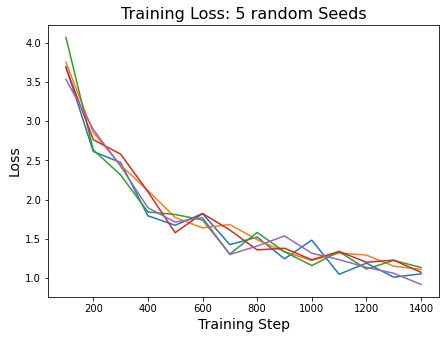

In [ ]:
import json
plt.figure(figsize=[7,5])
plt.xlabel("Training Step",fontsize = 14)
plt.ylabel("Loss",fontsize = 14)
plt.title("Training Loss: 5 random Seeds",fontsize = 16)
for random_seed in range(10,15):

  model_name = f"t5-base-text_description_{random_seed}"
  with open(f"drive/MyDrive/data2050/data/model_histories/{model_name}_history.json", "r") as f:
    obj = json.load(f)
  losses = obj[::2][:-2]
  x1 = []
  y1 = []
  for item in losses:
    x1.append(item["step"])
    y1.append(item["loss"])
  plt.plot(x1,y1)
plt.savefig("drive/MyDrive/data2050/training_loss.png",dpi = 300)

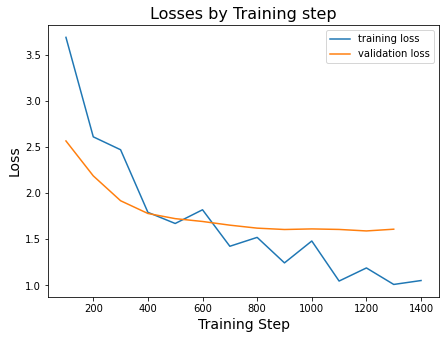

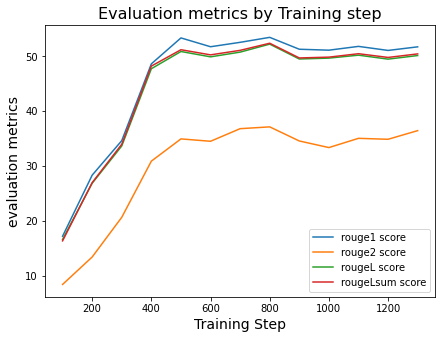

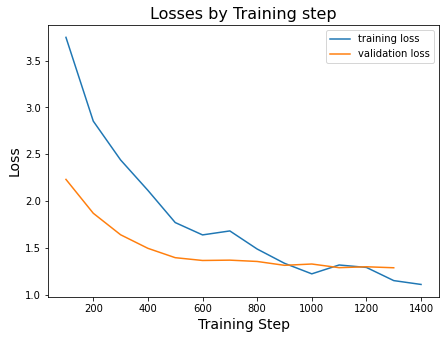

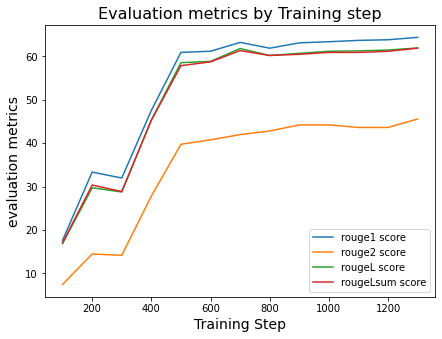

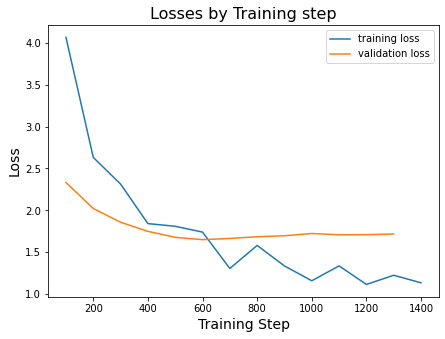

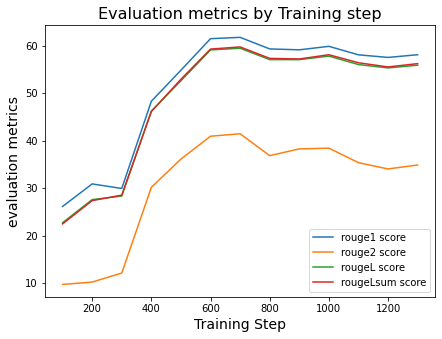

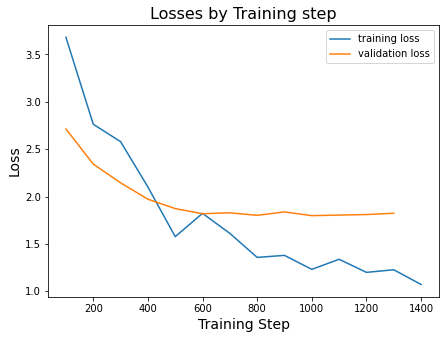

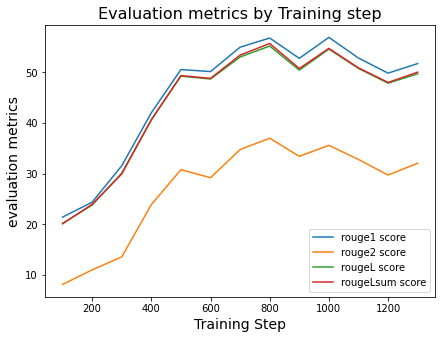

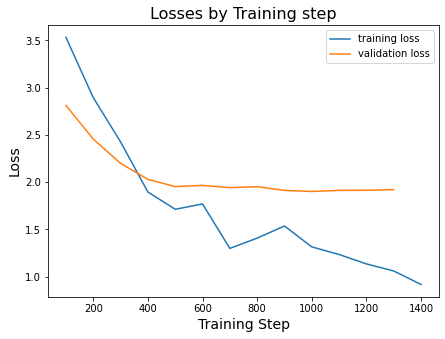

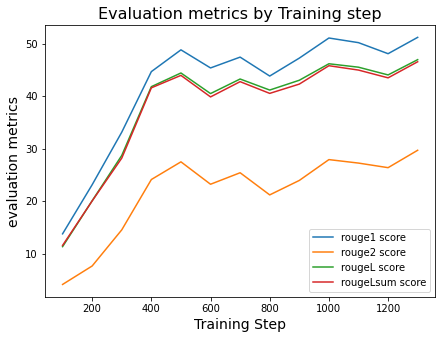

In [ ]:
for random_seed in range(10,15):
  model_name = f"t5-base-text_description_{random_seed}"
  with open(f"drive/MyDrive/data2050/data/model_histories/{model_name}_history.json", "r") as f:
    obj = json.load(f)
  plot_report(obj, str(random_seed))

In [ ]:
model_name = "t5-base-text_description-generation"
model_dir = f"drive/MyDrive/Models/{model_name}"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

max_input_length = 512

['<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad> a u.s. folk singer, James Francis Ferguson was born in Belfast.',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [ ]:

medium_datasets = load_dataset("csv", data_files="drive/MyDrive/medium_articles.csv.zip")
# DatasetDict({
#    train: Dataset({
#        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
#        num_rows: 192368
#    })
# })

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
medium_datasets

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
        num_rows: 192368
    })
})

In [ ]:

datasets_train_test = medium_datasets["train"].train_test_split(test_size=3000)
datasets_train_validation = datasets_train_test["train"].train_test_split(test_size=3000)

medium_datasets["train"] = datasets_train_validation["train"]
medium_datasets["validation"] = datasets_train_validation["test"]
medium_datasets["test"] = datasets_train_test["test"]

# DatasetDict({
#    train: Dataset({
#        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
#        num_rows: 186368
#    })
#    validation: Dataset({
#        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
#        num_rows: 3000
#    })
#    test: Dataset({
#        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
#        num_rows: 3000
#    })
# })

In [ ]:
medium_datasets["train"] = medium_datasets["train"].shuffle().select(range(100000))
medium_datasets["validation"] = medium_datasets["validation"].shuffle().select(range(1000))
medium_datasets["test"] = medium_datasets["test"].shuffle().select(range(1000))

# DatasetDict({
#    train: Dataset({
#        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
#        num_rows: 100000
#    })
#    validation: Dataset({
#        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
#        num_rows: 1000
#    })
#    test: Dataset({
#        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
#        num_rows: 1000
#    })
# })

In [ ]:
import nltk
nltk.download('punkt')
import string
from transformers import AutoTokenizer

model_checkpoint = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buck

In [ ]:

medium_datasets_cleaned = medium_datasets.filter(
    lambda example: (len(example['text']) >= 500) and
    (len(example['title']) >= 20)
)

  0%|          | 0/100 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
prefix = "summarize: "
max_input_length = 512
max_target_length = 64

def clean_text(text):
    sentences = nltk.sent_tokenize(text.strip())
    sentences_cleaned = [s for sent in sentences for s in sent.split("\n")]
    sentences_cleaned_no_titles = [sent for sent in sentences_cleaned
                                 if len(sent) > 0 and
                                 sent[-1] in string.punctuation]
    text_cleaned = "\n".join(sentences_cleaned_no_titles)
    return text_cleaned

def preprocess_data(examples):
    texts_cleaned = [clean_text(text) for text in examples["text"]]
    inputs = [prefix + text for text in texts_cleaned]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

      # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["title"], max_length=max_target_length, 
                           truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:

tokenized_medium_datasets = medium_datasets_cleaned.map(preprocess_data,batched=True)

# DatasetDict({
#    train: Dataset({
#        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags',
#                   'input_ids', 'attention_mask', 'labels'],
#        num_rows: 85602
#    })
#    validation: Dataset({
#        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags',
#                   'input_ids', 'attention_mask', 'labels'],
#        num_rows: 860
#    })
#    test: Dataset({
#        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags',
#                   'input_ids', 'attention_mask', 'labels'],
#        num_rows: 844
#    })
# })

  0%|          | 0/86 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
["train","validation","test"]
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 312
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 30
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 30
    })
})

In [ ]:
tokenized_medium_datasets["train"]["title"][0]

'Stress and Depression in a Covid World'

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq,Seq2SeqTrainingArguments, Seq2SeqTrainer

In [ ]:
batch_size = 8
model_name = "t5-base-text_description-generation"
model_dir = f"drive/MyDrive/Models/{model_name}"

args = Seq2SeqTrainingArguments(
    model_dir,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=200,
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    report_to="tensorboard"
)

PyTorch: setting up devices


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer)

In [ ]:
metric = load_metric("rouge")

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                      for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
                      for label in decoded_labels]
    
    # Compute ROUGE scores
    result = metric.compute(predictions=decoded_preds, references=decoded_labels,
                            use_stemmer=True)

    # Extract ROUGE f1 scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length to metrics
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                      for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
def model_init():
    return AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

trainer = Seq2SeqTrainer(
    model_init=model_init,
    args=args,
    train_dataset=tokenized_medium_datasets["train"],
    eval_dataset=tokenized_medium_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
  

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '{model_dir}'/runs

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |     850 MB |    2550 MB |    4251 MB |    3401 MB |\n|       from large pool |     850 MB |    2550 MB |    4250 MB |    3400 MB |\n|       from small pool |       0 MB |       0 MB |       0 MB |       0 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |     850 MB |    2550 MB |    4251 MB |    3401 MB |\n|       from large pool |     850 MB |    2550 MB |

In [ ]:
trainer.train()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/a4986abc64c580966eb8dd0ed61ceafaeb0d1d45/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
  

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
100,3.142700,2.646377,29.058200,13.723600,26.857700,26.857900,13.052600
200,2.773700,2.592956,30.700900,15.186800,28.646500,28.655700,11.501200
300,2.689100,2.564178,31.806000,15.991400,29.534600,29.516400,11.453300
400,2.633800,2.551529,31.420100,15.477700,29.303500,29.341400,11.628000
500,2.675600,2.530859,31.680300,15.843700,29.273600,29.338000,11.643500


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: url, authors, title, timestamp, text, tags. If url, authors, title, timestamp, text, tags are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 836
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: url, authors, title, timestamp, text, tags. If url, authors, title, timestamp, text, tags are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 836
  Batch size = 8
Saving model checkpoint to drive/MyDrive/Models/t5-base-text_description-generation/checkpoint-200
Configuration saved in drive/MyDrive/Models/t5-base-text_description-generation/checkpoint-200/config.json


KeyboardInterrupt: ignored

In [ ]:
model_name = "t5-base-medium-title-generation/checkpoint-2000"
model_dir = f"drive/MyDrive/Models/{model_name}"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

max_input_length = 512

NameError: ignored

In [ ]:
text = """
We define access to a Streamlit app in a browser tab as a session.
For each browser tab that connects to the Streamlit server, a new session is created.
Streamlit reruns your script from top to bottom every time you interact with your app.
Each reruns takes place in a blank slate: no variables are shared between runs.
Session State is a way to share variables between reruns, for each user session.
In addition to the ability to store and persist state, Streamlit also exposes the
ability to manipulate state using Callbacks. In this guide, we will illustrate the
usage of Session State and Callbacks as we build a stateful Counter app.
For details on the Session State and Callbacks API, please refer to our Session
State API Reference Guide. Also, check out this Session State basics tutorial
video by Streamlit Developer Advocate Dr. Marisa Smith to get started:
"""

inputs = ["summarize: " + text]

inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, return_tensors="pt")
output = model.generate(**inputs, num_beams=8, do_sample=True, min_length=10, max_length=64)
decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
predicted_title = nltk.sent_tokenize(decoded_output.strip())[0]

print(predicted_title)

In [ ]:
text = """
Many financial institutions started building conversational AI, prior to the Covid19
pandemic, as part of a digital transformation initiative. These initial solutions
were high profile, highly personalized virtual assistants — like the Erica chatbot
from Bank of America. As the pandemic hit, the need changed as contact centers were
under increased pressures. As Cathal McGloin of ServisBOT explains in “how it started,
and how it is going,” financial institutions were looking for ways to automate
solutions to help get back to “normal” levels of customer service. This resulted
in a change from the “future of conversational AI” to a real tactical assistant
that can help in customer service. Haritha Dev of Wells Fargo, saw a similar trend.
Banks were originally looking to conversational AI as part of digital transformation
to keep up with the times. However, with the pandemic, it has been more about
customer retention and customer satisfaction. In addition, new use cases came about
as a result of Covid-19 that accelerated adoption of conversational AI. As Vinita
Kumar of Deloitte points out, banks were dealing with an influx of calls about new
concerns, like questions around the Paycheck Protection Program (PPP) loans. This
resulted in an increase in volume, without enough agents to assist customers, and
tipped the scale to incorporate conversational AI. When choosing initial use cases
to support, financial institutions often start with high volume, low complexity
tasks. For example, password resets, checking account balances, or checking the
status of a transaction, as Vinita points out. From there, the use cases can evolve
as the banks get more mature in developing conversational AI, and as the customers
become more engaged with the solutions. Cathal indicates another good way for banks
to start is looking at use cases that are a pain point, and also do not require a
lot of IT support. Some financial institutions may have a multi-year technology
roadmap, which can make it harder to get a new service started. A simple chatbot
for document collection in an onboarding process can result in high engagement,
and a high return on investment. For example, Cathal has a banking customer that
implemented a chatbot to capture a driver’s license to be used in the verification
process of adding an additional user to an account — it has over 85% engagement
with high satisfaction. An interesting use case Haritha discovered involved
educating customers on financial matters. People feel more comfortable asking a
chatbot what might be considered a “dumb” question, as the chatbot is less judgmental.
Users can be more ambiguous with their questions as well, not knowing the right
words to use, as chatbot can help narrow things down.
"""

inputs = ["summarize: " + text]

inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, return_tensors="pt")
output = model.generate(**inputs, num_beams=8, do_sample=True, min_length=10, max_length=64)
decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
predicted_title = nltk.sent_tokenize(decoded_output.strip())[0]

print(predicted_title)

In [ ]:
model_name = "t5-base-medium-title-generation/checkpoint-3400"
model_dir = f"drive/MyDrive/Models/{model_name}"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

In [ ]:
text = "Decomposition of animal carrion is achieved primarily through the activities of invertebrates, such as flies and beetles, and large scavengers, generally other vertebrates such as opossums, raccoons, and vultures. Microbes, such as bacteria and fungi, are also important for carrion decomposition."

In [ ]:
inputs = ["summarize: " + text]

inputs = tokenizer(inputs, max_length=512, truncation=True, return_tensors="pt")
output = model.generate(**inputs, num_beams=8, do_sample=True, min_length=10, max_length=24)
decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
predicted_title = nltk.sent_tokenize(decoded_output.strip())[0]

print(predicted_title)

Tornado Cash (also stylized as TornadoCash) is an open source, non-custo


In [ ]:
medium_datasets.type()

AttributeError: ignored

In [ ]:
type(medium_datasets)

datasets.dataset_dict.DatasetDict

In [ ]:
train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
my_dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})